# EP1
## Cálculo do Conjunto de Mandelbrotem Paralelo com Pthreads e OpenMP

Nesse EP temos apenas quatro membros pois um trancou a materia:

| Nome | NUSP |
|------|------|
| Daniel Hotta | 9922700 |
| Matheus Laurentys | 9793714 |
| Pedro Gigeck | 10737136 |
| Rafael Gonçalves | 9009600 |


## Configuração do Ambiente

O ambiente será herdado do miniEP3

In [3]:
] up

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


   Updating `~/Área de Trabalho/EP1-DOMINGO/src/Project.toml`
 [no changes]
   Updating `~/Área de Trabalho/EP1-DOMINGO/src/Manifest.toml`
 [no changes]


In [4]:
] st

Status `~/Área de Trabalho/EP1-DOMINGO/src/Project.toml`
  [336ed68f] CSV v0.6.2
  [a93c6f00] DataFrames v0.21.1
  [31c24e10] Distributions v0.23.2
  [7073ff75] IJulia v1.21.2
  [8314cec4] PGFPlotsX v1.2.6
  [91a5bcdd] Plots v1.3.2
  [1a8c2f83] Query v0.12.2
  [f3b207a7] StatsPlots v0.14.6



## Medição do tempo

Para medir o tempo de execução geral, usamos o script `run_measurements.sh`, com o comando `perf`, que foi passado no enunciado.

As implementações paralelas (Pthreads e OpenMP) foram executadas com o número fixo de 16 threads.
Além disso o tamanho dos testes foi reduzido para 9, pois o tempo de rodar a sequência com 2^10 foi muito grande.

Para medir o tempo de execução descontando as operações de I/O e alocação de memória, usamos a opção do perf que separa o tempo de execução por cada comando específico do código, assim conseguimos obter o tempo gasto por cada função.

## Sobre as Implementações

A implementação sequencial `mandelbrot_seq.c` foi mantida intacta.

A implementação com OpenMP `mandelbrot_omp.c` foi bastante simples, o cálculo é igual ao sequêncial, porém o for externo foi trocado por um for paralelo do omp, compartilhando a váriavel `i_y`. Dessa forma, cada thread cuida de um intervalo de valores do `i_y`.

A implementação com Pthreads `mandelbrot_pth.c` seguiu a mesma lógica da com OMP, paralelizando o for externo. Cada thread recebe um `i_y` inicial e um `i_y` final e calcula as linhas esquivalentes a esse intervalo. A diferença é que as estruturas das threads e a divisão dos intervalos foram feitos explicitamente.

## Executando

O primeiro passo é compilar todo o codigo deste EP

In [5]:
; make

make: Nothing to be done for 'all'.


In [ ]:
Podemos rodar qualquer uma das implementações para observar as imagens, por exemplo

In [4]:
; ./mandelbrot_seq -2.5 1.5 -2.0 2.0 11500

usage: ./mandelbrot_seq c_x_min c_x_max c_y_min c_y_max image_size
examples with image_size = 11500:
    Full Picture:         ./mandelbrot_seq -2.5 1.5 -2.0 2.0 11500
    Seahorse Valley:      ./mandelbrot_seq -0.8 -0.7 0.05 0.15 11500
    Elephant Valley:      ./mandelbrot_seq 0.175 0.375 -0.1 0.1 11500
    Triple Spiral Valley: ./mandelbrot_seq -0.188 -0.012 0.554 0.754 11500


Por fim, rodamos os scripts com os experimentos

In [ ]:
; ./run_measurements.sh

  Resolving package versions...
   Updating `~/Área de Trabalho/EP1-DOMINGO/src/Project.toml`
 [no changes]
   Updating `~/Área de Trabalho/EP1-DOMINGO/src/Manifest.toml`
 [no changes]


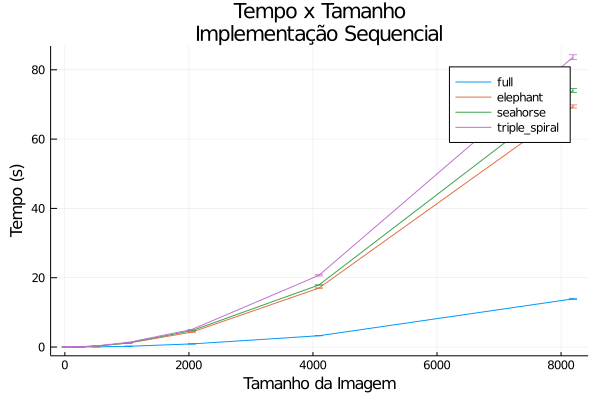

In [6]:
# Plot sequencial graph

import Pkg
Pkg.add("Plots")
using DataFrames, Plots

# Get the time values from the log files and saves in a string
function get_log_string(log)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results/mandelbrot_seq/$log.log`,
          pipeline(`awk '{print $1}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Get the percent values of the error from the log files and saves in a string
function get_log_deviation(log)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results/mandelbrot_seq/$log.log`,
          pipeline(`awk '{print $(NF - 1)}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Transform the strings of times and error into float arrays
function get_values(values, percent)
    values = split(values, '\n')
    percent = split(percent, '\n')
    pop!(values)
    pop!(percent)
    times = []
    error = []
    for i in 1:length(values)
        t = parse(Float64, replace(values[i], ","=>"."))
        push!(times, t)
        e = parse(Float64, replace(replace(percent[i], ","=>"."), "%"=>""))
        push!(error, (t*e)/100)
    end
    return times, error
end

# Create a dataframe with values from the 4 log files
function get_data_frame()
    logs = ["full", "elephant", "seahorse", "triple_spiral"];
    df = DataFrame()
    df.sz = [2 ^ x for x in 4:13]
    for l in logs
        s = get_log_string(l)
        d = get_log_deviation(l)
        
        times, dv = get_values(s, d)
        df[!, "$l"] = times
        df[!, "dv$l"] = dv
    end
    return df
end

function plot_data_frame(df)
    xs = df.sz
    ys = [df.full df.elephant df.seahorse df.triple_spiral]
    deviation = [df.dvfull df.dvelephant df.dvseahorse df.dvtriple_spiral]
    labels = ["full" "elephant" "seahorse" "triple_spiral"] 
    plot(xs, ys, label = labels, yerror = deviation, 
         xlabel = "Tamanho da Imagem", ylabel = "Tempo (s)", title = "Tempo x Tamanho\nImplementação Sequencial")
end

df = get_data_frame()
plot_data_frame(df)

In [12]:
# Plot the paralell graphs

import Pkg
Pkg.add("Plots")
using DataFrames, Plots

# Get the time values from the log files and saves in a string
function get_log_string(log, implementation, th)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results/mandelbrot_$implementation/$log$th.log`,
          pipeline(`awk '{print $1}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Get the percent values of the error from the log files and saves in a string
function get_log_deviation(log, implementation, th)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results/mandelbrot_$implementation/$log$th.log`,
          pipeline(`awk '{print $(NF - 1)}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Transform the strings of times and error into float arrays
function get_values(values, percent)
    values = split(values, '\n')
    percent = split(percent, '\n')
    pop!(values)
    pop!(percent)
    times = []
    error = []
    for i in 1:length(values)
        t = parse(Float64, replace(values[i], ","=>"."))
        push!(times, t)
        e = parse(Float64, replace(replace(percent[i], ","=>"."), "%"=>""))
        push!(error, (t*e)/100)
    end
    return times, error
end

# Get a dataFrame (time x image_size) with data  
function get_data_frame(implementation,image)
    df = DataFrame()
    df.sz = [2 ^ x for x in 4:13]
    th = [2 ^ x for x in 0:4]
    for t in th
        s = get_log_string(image, implementation, string(t))
        d = get_log_deviation(image, implementation, string(t))
        
        times, dv = get_values(s, d)
        df[!, "t$t"] = times
        df[!, "dv$t"] = dv
    end
    return df
end

# Função para plotar o DataFrame
function plot_data_frame(df, i, j)
    xs = df.sz
    ys = [df.t1 df.t2 df.t4 df.t8 df.t16]
    deviation = [df.dv1 df.dv2 df.dv4 df.dv8 df.dv16]
    labels = ["1" "2" "4" "8" "16"]
    display(plot(xs, ys, label = labels, yerror = deviation, 
         xlabel = "Tamanho da Imagem", ylabel = "Tempo (s)", title = "Tempo x Tamanho\nImplementação $i - $j"))
end

implementations = ["omp"]
file = ["triple_spiral","seahorse","elephant","full"]
for i in implementations
    for j in file
        df = get_data_frame(i, j)
        plot_data_frame(df, i, j)
    end
end

  Resolving package versions...
   Updating `~/Área de Trabalho/EP1-DOMINGO/src/Project.toml`
 [no changes]
   Updating `~/Área de Trabalho/EP1-DOMINGO/src/Manifest.toml`
 [no changes]


ArgumentError: ArgumentError: New columns must have the same length as old columns

In [11]:
using Pkg
Pkg.add("DataFrames")

using DataFrames

function get_df_time(path) 
    overhead = []
    system = []
    open(path) do f
        for i in eachline(f)
            if occursin(r".+[0-9]+.[0-9]+%", i)
                x = split(i)
                tmp = split(x[1], "%")
                push!(overhead, parse(Float64, tmp[1]))
                push!(system, x[5])
            end
        end
    end
    return df = DataFrame(A = overhead, B = system)
end


df = (get_df_time("results_inter/mandelbrot_seq/full.log"))


function get_time(df)
    time = [0.0, 0.0, 0.0]

    for i in eachrow(df)
        if occursin(r".*mandelbrot.*", i[2,])
            time[1] += i[1, ]
        elseif occursin(r".*malloc.*", i[2,]) || occursin(r".*IO.*", i[2,]) 
            time[2] += i[1, ]
        else 
            time[3] += i[1, ]
        end
    end
    return time
end

println(typeof(get_time(df)))


function get_all()
    mandel = ["omp", "pth"]
    logs = ["elephant8", "full8", "seahorse8", "triple_spiral8"]
    
    times = []
    
    files = []
    
    for i in mandel
        for j in logs
            tmp_df = (get_df_time("results_inter/mandelbrot_$i/$j.log"))
            push!(times, get_time(tmp_df))
            push!(files, "$i/$j")
        end
    end
    
    return df = DataFrame(A = times, B = files)
end

println(get_all())

  Resolving package versions...
   Updating `~/Área de Trabalho/EP1-DOMINGO/src/Project.toml`
 [no changes]
   Updating `~/Área de Trabalho/EP1-DOMINGO/src/Manifest.toml`
 [no changes]


Array{Float64,1}
8×2 DataFrame
│ Row │ A                    │ B                  │
│     │ Any                  │ Any                │
├─────┼──────────────────────┼────────────────────┤
│ 1   │ [86.99, 2.53, 10.47] │ omp/elephant8      │
│ 2   │ [46.69, 9.9, 43.39]  │ omp/full8          │
│ 3   │ [87.42, 2.37, 10.21] │ omp/seahorse8      │
│ 4   │ [88.95, 2.11, 8.95]  │ omp/triple_spiral8 │
│ 5   │ [95.75, 2.62, 1.63]  │ pth/elephant8      │
│ 6   │ [74.82, 15.43, 9.72] │ pth/full8          │
│ 7   │ [96.01, 2.46, 1.53]  │ pth/seahorse8      │
│ 8   │ [96.42, 2.1, 1.47]   │ pth/triple_spiral8 │


## Implementação Paralela com *pthreads* e OpenMP


• 1) Como e por que as três versões do programa se comportam com a variação:

– Do tamanho da entrada?

– Das regiões do Conjunto de Mandelbrot?

– Do número de threads?




### Analise da implementação sequencial

Com a implementação sequencial, vemos uma clara diferença entre as regiões do Conjunto de Mandelbrot. 

A geração da imagem completa (full) consome muito menos tempo que as regiões específicas, uma das causas pode ser o grande intervalo de pontos que cada pixel da imagem abrange, causando uma baixa definição e, com isso, menos iterações de cálculo. As regiões específicas, que cobriam subconjuntos de tamanhos semelhantes consumiram tempos parecidos. 

Outra observação interessante é o comportamento quadrático do consumo de tempo em função do tamanho da lateral imagem, o que faz sentido já que calculamos um dado número de iterações para cada pixel.

### Analise geral das implementações paralelas

No entanto,com as implementeções paralelas conseguimos observar que ,aparentemente, o Conjunto de Mandelbrot paralelizado por
pthreads apresenta um menor tempo para o calculo quando temos 8 threads. 

Além disso, fica evidente uma diferença gritante na maneira em que a evolução do tempo para o calculo das imagens se comporta independente do numero de threads involvido, dado a implementação ser por OpenMP e Pthreads, pois os graficos gerados pela implementação OpenMP apresentam um tempo de execução e taxa de crescimento similar para n threads para as regiões pedidas, enquanto ao nos voltarmos para os graficos gerados pela implementação pthreads temos taxas de crescimento para o tempo de execução por numero de threads mais distintas entre si.




### Analise da implementação com *pthreads*

Aparentemente o tempo de execução aumenta ainda que aumentamos o numero de threads, com exceção de quando rodamos
imagens com 8 threads provavelmente pois , assim como ocorreu no miniep anterior, a quantidade de threads acaba 
ficando muito maior que a quantidade de núcleos de processamento da máquina, assim, não temos um ganho real 
dividindo o trabalho, pois ele terá que ser executado nos mesmos núcleos. Todavia ainda vemos que ainda ganhamos tempo se comparado com a execução sequencial e que assim como na execução sequencial a geração da imagem completa(full) é mais rapida de ser calculada.

### Analise da implementação com OpenMP

Como ja foi dito, a implementação por OpenMP apresentam um tempo de execução e taxa de crescimento similar para n threads para as regiões pedidas, todavia apresentam um tempo consideravelmente mais rapido para determinadas imagens com relação a outras, em especial a imagem denominada " full ".

• 2) Qual o impacto das operações de I/O e alocação de memória no tempo de execução?

## Exercício 3: Análise de Desempenho

Agora, escreva uma função **em Julia** chamada `save_csv_results`, que recebe um `DataFrame` e um nome de arquivo, e escreve o `DataFrame` em disco, no formato `.csv`, com o nome passado no argumento.

Utilize a biblioteca [CSV](https://juliadata.github.io/CSV.jl/stable/), já instalada no ambiente deste notebook.

In [ ]:
using DataFrames, Query, StatsPlots, Statistics

function measure_(size, f, threads)
    results = parse.(Float64,
        split(chomp(read(`./monte_carlo $size $f $threads`, String)), ", "))
        
    return DataFrame(size = size,
        f = f,
        threads = threads,
        estimate = results[1],
        duration = results[2])
end

In [7]:
using CSV

function save_csv_results(results, filename)
    CSV.write(filename, results)
end

save_csv_results (generic function with 1 method)

Escreva uma função **em Julia** chamada `read_csv_results`, que recebe um nome de arquivo e lê o arquivo correspondente, devolvendo um `DataFrame`.

In [8]:
function read_csv_results(filename)
    new_df = CSV.read(filename)
    return new_df
end

read_csv_results (generic function with 1 method)

Salve o DataFrame `results` em disco. **Vocês devem entregar o .csv também**.

In [9]:
save_csv_results(parsed_results, "parsed-results.csv")

"parsed-results.csv"

In [10]:
test = read_csv_results("parsed-results.csv")

,threads,mean_estimate,ci_estimate,mean_duration,ci_duration,target
,Int64,Float64,Float64,Float64,Float64,String
1,1,3.14158,0.000983252,9.46824,0.39267,π
2,2,3.14187,0.00108471,11.1466,0.437106,π
3,4,3.14164,0.000885962,19.4511,7.01746,π
4,8,3.1416,0.000516702,20.8351,0.977543,π
5,16,3.14133,0.00100813,17.917,0.335727,π
6,32,3.14144,0.000922017,15.4421,0.696022,π
7,64,3.14147,0.000941138,13.1624,1.48958,π
8,128,3.14152,0.000759412,12.5555,1.1203,π
9,256,3.1418,0.000432586,12.0307,2.81153,π


### Exercício 3b)

Como vocês já se familiarizaram um pouco com funções para geração de gráficos no miniEP1&2, explique o que faz a função `plot_results` abaixo. Ela é uma generalização das funções usadas no miniEP anterior. Para ajudar, você pode modificar e usar as chamadas de função no **Exercício 3c)**.

Essa função faz um scatter plot dos resultados dos experimentos em função do número de threads em escala logarítmica, podendo incluir ou não o erro em y e uma linha horizontal.

In [11]:
pgfplotsx()

function plot_results(x, y, target_label, series_label; hline = [], yerror = [], max_thread_power = 10)      
    if yerror != []
        p = scatter(x,
            y,
            xaxis = :log2,
            xlabel = "Threads",
            xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror,
            alpha = 0.6,
            labels = series_label,
            legend = :topright)
    else
        p = scatter(x,
            y,
            xaxis = :log2,
            xlabel = "Threads",
            xticks = [2 ^ x for x in 0:max_thread_power],
            alpha = 0.6,
            labels = series_label,
            legend = :topright)
    end
    
    if hline != []
        plot!(x,
            hline,
            xaxis = :log2,
            xlabel = "Threads",
            xticks = [2 ^ x for x in 0:max_thread_power],
            labels = target_label,                             
            line = :dash,                    
            width = 2.0)
    end
    
    return p
end

plot_results (generic function with 1 method)

#### Gerando Gráficos

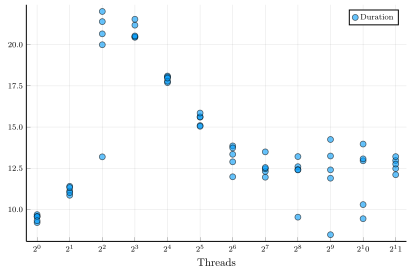

In [12]:
plot_results(results.threads,
    results.duration,    
    "pi",
    "Duration",
    max_thread_power = 11)

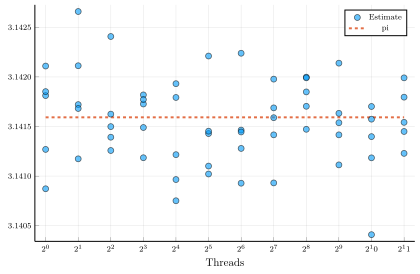

In [13]:
plot_results(results.threads,
    results.estimate,    
    "pi",
    "Estimate",
    hline = [pi for i in 1:nrow(results)],
    max_thread_power = 11)

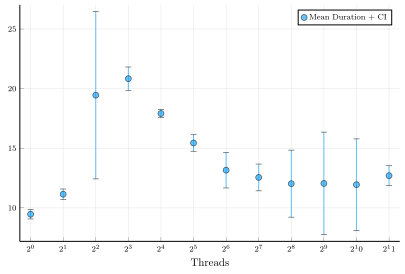

In [14]:
plot_results(parsed_results.threads,
    parsed_results.mean_duration,
    "pi",
    "Mean Duration + CI",
    yerror = parsed_results.ci_duration,
    max_thread_power = 11)

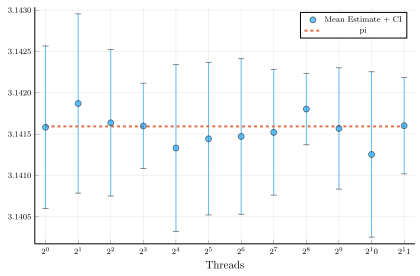

In [15]:
plot_results(parsed_results.threads,
    parsed_results.mean_estimate,
    "pi",
    "Mean Estimate + CI",
    hline = [pi for i in 1:nrow(parsed_results)],
    yerror = parsed_results.ci_estimate,
    max_thread_power = 11)